<font color = blue><font size = 6> H(ALF)DLSTM </font></font><br>
DLSTM에서 LSTM을 양쪽(seasonal,trend) 모두에 적용을 해서 안좋은 결과가 나온거 같다고 예상이 돼서 seasonal에만 적용을 한번 해보겠다 또한 여기서는 데이터를 분해하기전에 scaling(multiplication)을 진행했다
+ 이번에는 Sample3에 대해서 진행해보겠다

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [20]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [21]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [22]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [23]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [24]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [25]:
tup= (1,2)
len(tup)

2

In [26]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [27]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [28]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        
        self.Linear_Trend = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.to(self.device) 

        _,final_season_hidden = self.season_encoder(seasonal_init)
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output = self.Linear_Trend(trend_init)
        
        output = (trend_output+season_output)*div_factor
        
        return output,season_output,trend_output

In [29]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [30]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [31]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [32]:
target

tensor([[[0.2092]],

        [[0.2202]],

        [[0.2011]],

        ...,

        [[0.1768]],

        [[0.1615]],

        [[0.1736]]], device='cuda:0')

In [33]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),6*1e-7)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 6.0000e-07.


In [34]:
torch.manual_seed(42)

In [35]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [36]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 5.7000e-07.
smape 108.29118697005407 %
Adjusting learning rate of group 0 to 5.4150e-07.
smape 27.539627787313965 %
Adjusting learning rate of group 0 to 5.1442e-07.
smape 14.134701731783606 %
Adjusting learning rate of group 0 to 4.8870e-07.
smape 13.931069244243947 %
Adjusting learning rate of group 0 to 4.6427e-07.
smape 13.88486394582436 %
Adjusting learning rate of group 0 to 4.4106e-07.
smape 13.830113912012147 %
Adjusting learning rate of group 0 to 4.1900e-07.
smape 13.769871463116848 %
Adjusting learning rate of group 0 to 3.9805e-07.
smape 13.71115206844277 %
Adjusting learning rate of group 0 to 3.7815e-07.
smape 13.651552379828447 %
Adjusting learning rate of group 0 to 3.5924e-07.
smape 13.59367402542753 %
Adjusting learning rate of group 0 to 3.4128e-07.
smape 13.541056567378213 %
Adjusting learning rate of group 0 to 3.2422e-07.
smape 13.490958112286544 %
Adjusting learning rate of group 0 to 3.0801e-07.
smape 13.443440788409166 %
Ad

In [37]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 4.722240246832371 %
SMAPE 26.240113496780392 %
SMAPE 12.640901654958725 %
SMAPE 6.793719157576561 %
SMAPE 9.064788661897182 %
SMAPE 9.68852886557579 %
SMAPE 0.8649680698290467 %
SMAPE 6.822681292891502 %
SMAPE 6.885177597403526 %
SMAPE 2.295591965317726 %
SMAPE 4.8506994135677814 %
SMAPE 20.417063668370247 %
SMAPE 7.188274770975113 %
SMAPE 1.123587280511856 %
SMAPE 13.945792093873024 %
SMAPE 1.1700644623488188 %
SMAPE 8.665597677230835 %
SMAPE 8.630452655255795 %
SMAPE 3.9035878479480743 %
SMAPE 2.4296359587460756 %
SMAPE 9.211655348539352 %
SMAPE 12.339872315526009 %
SMAPE 5.160911291837692 %
SMAPE 7.308447115123272 %
SMAPE 4.659760694950819 %
SMAPE 3.2097533866763115 %
SMAPE 13.86278010904789 %
SMAPE 6.551747888326645 %
SMAPE 7.846105054020882 %
SMAPE 11.207413047552109 %
SMAPE 11.38900900632143 %
SMAPE 12.1460762321949 %
SMAPE 4.547568254172802 %
SMAPE 5.241141319274902 %
SMAPE 2.1874007675796747 %
SMAPE 1.5809844294562936 %
SMAPE 14.401683181524277 %
SMAPE 9.143540352582932 %

SMAPE 14.189424514770508 %
SMAPE 3.4559357576072216 %
SMAPE 5.857490606606007 %
SMAPE 11.916314341127872 %
SMAPE 4.557408761233091 %
SMAPE 11.886598035693169 %
SMAPE 1.3391677467152476 %
SMAPE 0.8671354856342078 %
SMAPE 3.270929519087076 %
SMAPE 4.362658109515905 %
SMAPE 14.140282958745956 %
SMAPE 3.9511218927800655 %
SMAPE 0.3928904873318971 %
SMAPE 6.923454515635967 %
SMAPE 5.914888791739941 %
SMAPE 9.338136680424213 %
SMAPE 1.9512580316513775 %
SMAPE 9.114717781543732 %
SMAPE 8.685028694570065 %
SMAPE 6.698088258504868 %
SMAPE 22.218102157115936 %
SMAPE 7.815381087362766 %
SMAPE 1.3967917440459132 %
SMAPE 5.787665091454983 %
SMAPE 4.213498797267675 %
SMAPE 7.668451897799969 %
SMAPE 0.15219591441564262 %
SMAPE 2.1656810268759727 %
SMAPE 5.441133435815573 %
SMAPE 4.511731754988432 %
SMAPE 14.35036167502403 %
SMAPE 1.4925284618511796 %
SMAPE 3.5745290368795395 %
SMAPE 7.221700802445412 %
SMAPE 3.103527208790183 %
SMAPE 15.078396826982498 %
SMAPE 13.280151784420013 %
SMAPE 2.83979180268

SMAPE 9.009411685168743 %
SMAPE 0.11591052066069096 %
SMAPE 5.2923749424517155 %
SMAPE 3.663086511194706 %
SMAPE 14.13017889857292 %
SMAPE 7.984287083148957 %
SMAPE 3.548950180411339 %
SMAPE 3.256230600178242 %
SMAPE 0.06738947742269374 %
SMAPE 5.572466466575861 %
SMAPE 19.391849115490913 %
SMAPE 10.558676823973656 %
SMAPE 2.4807485956698656 %
SMAPE 3.466090802103281 %
SMAPE 16.38722825050354 %
SMAPE 5.76000064983964 %
SMAPE 0.1506913041230291 %
SMAPE 2.857176173478365 %
SMAPE 4.760102152824402 %
SMAPE 5.665298514068127 %
SMAPE 7.388222895562649 %
SMAPE 4.486543338745832 %
SMAPE 3.1960964798927307 %
SMAPE 3.655290823429823 %
SMAPE 12.240945510566235 %
SMAPE 11.398255005478859 %
SMAPE 2.770564680919051 %
SMAPE 2.221666559576988 %
SMAPE 5.42218728736043 %
SMAPE 4.448415670543909 %
SMAPE 10.1299521997571 %
SMAPE 10.150395974516869 %
SMAPE 4.099964562803507 %
SMAPE 8.36889985948801 %
SMAPE 9.603697881102562 %
SMAPE 11.534550733864307 %
SMAPE 6.476081892848015 %
SMAPE 3.078703982755542 %
SM

SMAPE 4.669787388294935 %
SMAPE 0.08091830852208659 %
SMAPE 6.931813687086105 %
SMAPE 12.090423107147217 %
SMAPE 11.29227976500988 %
SMAPE 2.4355798065662384 %
SMAPE 4.5770613588392735 %
SMAPE 5.592227831482887 %
SMAPE 5.54765610024333 %
SMAPE 6.800695680081844 %
SMAPE 0.7537444769404829 %
SMAPE 2.35099115408957 %
SMAPE 2.4065474569797516 %
SMAPE 9.695977337658405 %
SMAPE 6.1307274885475636 %
SMAPE 3.0364259406924248 %
SMAPE 3.366300869733095 %
SMAPE 7.249629005789757 %
SMAPE 6.733564272522926 %
SMAPE 10.582420520484447 %
SMAPE 5.924972373992205 %
SMAPE 3.9401750080287457 %
SMAPE 1.1488588843494654 %
SMAPE 15.217386454343796 %
SMAPE 6.192213498055935 %
SMAPE 7.621170699596405 %
SMAPE 3.7755739614367485 %
SMAPE 3.6870093159377575 %
SMAPE 2.3769439850002527 %
SMAPE 22.976176276803017 %
SMAPE 14.53489200770855 %
SMAPE 9.027617424726486 %
SMAPE 5.384006388485432 %
SMAPE 15.91559839248657 %
SMAPE 8.33504681289196 %
SMAPE 2.9187978245317936 %
SMAPE 4.4156326204538345 %
SMAPE 3.77412109822034

SMAPE 7.9292355328798285 %
SMAPE 0.5196439702995121 %
SMAPE 0.20173940598033369 %
SMAPE 5.190112765878439 %
SMAPE 15.249432176351545 %
SMAPE 11.49277551472187 %
SMAPE 0.9069226309657097 %
SMAPE 0.6958703869022429 %
SMAPE 1.4081557421013713 %
SMAPE 5.5701257809996605 %
SMAPE 9.716789811849594 %
SMAPE 2.646599229425192 %
SMAPE 0.02342060949797542 %
SMAPE 2.215852716937661 %
SMAPE 11.959774024784565 %
SMAPE 7.7476513758301735 %
SMAPE 0.00585990581045337 %
SMAPE 3.4309238940477367 %
SMAPE 2.3053194787353277 %
SMAPE 5.312602184712887 %
SMAPE 27.434049159288403 %
SMAPE 16.61450020968914 %
SMAPE 12.67676393687725 %
SMAPE 7.23400168120861 %
SMAPE 22.810111716389656 %
SMAPE 0.6194093357771635 %
SMAPE 7.912419632077217 %
SMAPE 10.130712188780308 %
SMAPE 7.30738539993763 %
SMAPE 8.97307052463293 %
SMAPE 18.472642317414284 %
SMAPE 8.272857531905174 %
SMAPE 4.288872420787811 %
SMAPE 4.092340484261513 %
SMAPE 15.489680707454681 %
SMAPE 1.8658458497375252 %
SMAPE 3.9038098640739918 %
SMAPE 0.61337963

SMAPE 0.3431611782871187 %
SMAPE 12.583873614668848 %
SMAPE 3.425405997782946 %
SMAPE 2.0043452568352222 %
SMAPE 4.895948465913534 %
SMAPE 10.435742668807507 %
SMAPE 6.93179714679718 %
SMAPE 5.090393628925085 %
SMAPE 4.808762855827808 %
SMAPE 5.728570401668549 %
SMAPE 3.79867560043931 %
SMAPE 25.356666177511215 %
SMAPE 11.687127217650414 %
SMAPE 1.319144431501627 %
SMAPE 3.487762223929167 %
SMAPE 7.487703539431095 %
SMAPE 12.577259436249733 %
SMAPE 2.4730848018079996 %
SMAPE 3.9822065494954586 %
SMAPE 2.8366237059235573 %
SMAPE 3.017255747690797 %
SMAPE 13.279980897903442 %
SMAPE 7.120286338031293 %
SMAPE 4.636398673057556 %
SMAPE 11.533154256641865 %
SMAPE 6.698609448969364 %
SMAPE 16.601855367422104 %
SMAPE 8.950621664524078 %
SMAPE 2.6303119752556086 %
SMAPE 5.6700429469347 %
SMAPE 3.5386962667107587 %
SMAPE 10.290813617408276 %
SMAPE 8.064349062740803 %
SMAPE 7.092004202306271 %
SMAPE 12.661461561918259 %
SMAPE 6.398775815963745 %
SMAPE 19.03244812786579 %
SMAPE 9.658361241221428 %

SMAPE 9.912846259772778 %
SMAPE 25.17567890882492 %
SMAPE 13.796592369675636 %
SMAPE 11.194719843566418 %
SMAPE 4.343092560768127 %
SMAPE 10.160119101405144 %
SMAPE 6.6229347959160805 %
SMAPE 6.02574198693037 %
SMAPE 0.1286712223663926 %
SMAPE 2.7056078631430864 %
SMAPE 3.7526423633098602 %
SMAPE 18.366348788142204 %
SMAPE 11.637477166950703 %
SMAPE 7.337755851447582 %
SMAPE 6.4458621218800545 %
SMAPE 11.890310928225517 %
SMAPE 0.4845501617528498 %
SMAPE 0.23969349800609052 %
SMAPE 5.712666392326355 %
SMAPE 2.2456958163529634 %
SMAPE 0.010293789453839963 %
SMAPE 18.17327542603016 %
SMAPE 15.416114225983621 %
SMAPE 6.153741080313921 %
SMAPE 10.318693101406097 %
SMAPE 10.888299725949764 %
SMAPE 2.134461633861065 %
SMAPE 1.7237214036285877 %
SMAPE 11.797474086284637 %
SMAPE 3.6069537848234177 %
SMAPE 7.291418552398682 %
SMAPE 22.17490327358246 %
SMAPE 4.007171280682087 %
SMAPE 2.0991392452269793 %
SMAPE 5.728783309459686 %
SMAPE 8.618562169373035 %
SMAPE 5.537269841879606 %
SMAPE 0.791276

SMAPE 4.907469492405653 %
SMAPE 14.444064661860468 %
SMAPE 7.5988901779055595 %
SMAPE 0.3190735892858356 %
SMAPE 8.685729995369911 %
SMAPE 5.116076674312353 %
SMAPE 6.366432696580887 %
SMAPE 4.6136033572256565 %
SMAPE 5.723322607576847 %
SMAPE 13.976654961705206 %
SMAPE 10.552775926887989 %
SMAPE 6.924620665609836 %
SMAPE 2.6319675650447607 %
SMAPE 7.0601664409041405 %
SMAPE 6.3877123445272455 %
SMAPE 2.0315585900098085 %
SMAPE 12.81078912317753 %
SMAPE 2.500938441604376 %
SMAPE 5.720421273261309 %
SMAPE 7.10516107827425 %
SMAPE 8.12801343947649 %
SMAPE 15.691074222326279 %
SMAPE 2.5787463318556547 %
SMAPE 2.258101286366582 %
SMAPE 4.985786829143763 %
SMAPE 8.462310269474983 %
SMAPE 4.699979029595852 %
SMAPE 2.981983134523034 %
SMAPE 0.012669037151340488 %
SMAPE 5.061858162283897 %
SMAPE 9.53678547590971 %
SMAPE 9.03556989878416 %
SMAPE 4.026396457105875 %
SMAPE 1.4979730928316712 %
SMAPE 0.00034055863418558374 %
SMAPE 5.655114226043224 %
SMAPE 12.286066941916943 %
SMAPE 5.846407625824

SMAPE 3.643235612660647 %
SMAPE 10.517370291054249 %
SMAPE 6.366409048438072 %
SMAPE 0.9829258695244789 %
SMAPE 4.750487182289362 %
SMAPE 5.635552398860455 %
SMAPE 2.0950523000210524 %
SMAPE 1.599314348772168 %
SMAPE 1.9905541073530912 %
SMAPE 3.0775174852460623 %
SMAPE 3.176604408770799 %
SMAPE 18.529387399554253 %
SMAPE 3.2739293165504932 %
SMAPE 2.144597725942731 %
SMAPE 6.031446598470211 %
SMAPE 7.646623745560646 %
SMAPE 2.2325565963983536 %
SMAPE 1.7524667326360943 %
SMAPE 1.0126120122149587 %
SMAPE 0.5676700929179788 %
SMAPE 6.665845103561878 %
SMAPE 6.5594299137592325 %
SMAPE 0.704680840484798 %
SMAPE 0.8399887839332223 %
SMAPE 6.4862077459692955 %
SMAPE 9.046211935579777 %
SMAPE 0.28069850942119956 %
SMAPE 0.10176944406703115 %
SMAPE 2.9714506193995476 %
SMAPE 6.396786168217659 %
SMAPE 2.9276606682688 %
SMAPE 8.39151531457901 %
SMAPE 1.1754763582721353 %
SMAPE 1.9294109251350162 %
SMAPE 7.438888125121594 %
SMAPE 8.51929271966219 %
SMAPE 0.24974275613203642 %
SMAPE 2.09785700030

SMAPE 1.7072302848100664 %
SMAPE 5.130118679255247 %
SMAPE 23.697449207305908 %
SMAPE 10.55705837905407 %
SMAPE 4.240593582391739 %
SMAPE 2.5547850225120783 %
SMAPE 7.068244434893131 %
SMAPE 1.6354993786662817 %
SMAPE 3.31574634462595 %
SMAPE 1.4533703410997987 %
SMAPE 1.8291626572608948 %
SMAPE 4.4900622852146626 %
SMAPE 11.532155364751816 %
SMAPE 8.749865338206291 %
SMAPE 2.661843406036496 %
SMAPE 6.530714079737663 %
SMAPE 8.129824183881283 %
SMAPE 1.9561515599489214 %
SMAPE 1.8591220565140245 %
SMAPE 1.3154744682833552 %
SMAPE 4.925803076475859 %
SMAPE 4.384283754974604 %
SMAPE 10.135153785347939 %
SMAPE 6.152507305145264 %
SMAPE 4.9814162738621235 %
SMAPE 5.1011700592935085 %
SMAPE 4.110449269413948 %
SMAPE 1.2040975401178002 %
SMAPE 3.4629723951220512 %
SMAPE 6.52799292653799 %
SMAPE 3.506638873368502 %
SMAPE 3.3809867054224014 %
SMAPE 27.607674002647396 %
SMAPE 15.739988282322884 %
SMAPE 11.334166176617146 %
SMAPE 1.098027584142983 %
SMAPE 5.773009747266769 %
SMAPE 1.146565753966

SMAPE 9.995580196380615 %
SMAPE 10.593357637524605 %
SMAPE 5.732807103544474 %
SMAPE 1.0211417460814118 %
SMAPE 8.711783282458782 %
SMAPE 1.5252696564421058 %
SMAPE 6.347860984504222 %
SMAPE 10.86490898579359 %
SMAPE 5.6840083338320255 %
SMAPE 9.450447857379913 %
SMAPE 8.286213651299477 %
SMAPE 13.659992367029188 %
SMAPE 3.8355752751231194 %
SMAPE 1.2804780099540949 %
SMAPE 8.310039535164833 %
SMAPE 0.13952730933669955 %
SMAPE 20.822646006941795 %
SMAPE 4.352941792458296 %
SMAPE 11.406092017889023 %
SMAPE 10.119362451136112 %
SMAPE 12.249454453587532 %
SMAPE 15.636056944727898 %
SMAPE 6.38557605445385 %
SMAPE 5.307758495211601 %
SMAPE 2.762299867346883 %
SMAPE 4.574533499777317 %
SMAPE 9.813401274383068 %
SMAPE 13.40137766301632 %
SMAPE 13.136462196707727 %
SMAPE 9.829265221953392 %
SMAPE 12.209758035838604 %
SMAPE 15.430409580469131 %
SMAPE 2.236845228821039 %
SMAPE 2.9320344887673855 %
SMAPE 11.129197984933853 %
SMAPE 0.6027405960485339 %
SMAPE 6.180452682077885 %
SMAPE 12.9151895493

SMAPE 1.0633571799844503 %
SMAPE 11.81594206392765 %
SMAPE 7.893638715147971 %
SMAPE 1.0663848547264934 %
SMAPE 1.3700317526236176 %
SMAPE 4.1283979043364525 %
SMAPE 3.1559240184724326 %
SMAPE 2.7855588383972645 %
SMAPE 0.40087277675047517 %
SMAPE 3.7663904651999474 %
SMAPE 6.337470196187496 %
SMAPE 26.096374839544296 %
SMAPE 16.253021493554115 %
SMAPE 6.083560187369585 %
SMAPE 1.0239327298477292 %
SMAPE 0.8977218344807626 %
SMAPE 4.417521454393864 %
SMAPE 6.055987276136875 %
SMAPE 2.41738248616457 %
SMAPE 5.528131831437349 %
SMAPE 9.123622372746468 %
SMAPE 13.33596710860729 %
SMAPE 11.519892930984497 %
SMAPE 3.7631363160908227 %
SMAPE 4.919352259486914 %
SMAPE 0.3686846415512264 %
SMAPE 3.025388613343239 %
SMAPE 6.16040325909853 %
SMAPE 2.757344914600253 %
SMAPE 8.848231472074986 %
SMAPE 8.548125982284546 %
SMAPE 7.760067231953144 %
SMAPE 7.663962192833424 %
SMAPE 2.120325356721878 %
SMAPE 1.8341714683920145 %
SMAPE 2.584629053249955 %
SMAPE 0.9568763403221966 %
SMAPE 0.33014547848142

SMAPE 3.210827801376581 %
SMAPE 15.741532176733017 %
SMAPE 13.614920809864998 %
SMAPE 5.100936438888311 %
SMAPE 1.7313105966895819 %
SMAPE 2.673121301457286 %
SMAPE 0.37899359036237 %
SMAPE 4.90640264749527 %
SMAPE 5.246628221124411 %
SMAPE 3.3930079005658627 %
SMAPE 3.194768119603395 %
SMAPE 11.54980967193842 %
SMAPE 6.786941431462765 %
SMAPE 1.4637767067179084 %
SMAPE 4.003629915416241 %
SMAPE 4.63487383723259 %
SMAPE 2.764017190784216 %
SMAPE 4.521121516823769 %
SMAPE 5.32853776216507 %
SMAPE 4.10734423622489 %
SMAPE 1.8133896458894012 %
SMAPE 1.6971494164317849 %
SMAPE 12.713218361139297 %
SMAPE 3.659618467092514 %
SMAPE 5.124829757958651 %
SMAPE 0.14760930999182165 %
SMAPE 0.7324169976636767 %
SMAPE 2.1549157053232193 %
SMAPE 0.07970681460574269 %
SMAPE 4.73841941729188 %
SMAPE 6.456973634660244 %
SMAPE 13.607293128967285 %
SMAPE 6.05255613476038 %
SMAPE 3.566720187664032 %
SMAPE 2.948739890009165 %
SMAPE 4.1879615262150764 %
SMAPE 1.42319767922163 %
SMAPE 0.3498450666666031 %
SMA

SMAPE 7.676035091280937 %
SMAPE 12.810633659362795 %
SMAPE 2.911312099546194 %
SMAPE 0.99418621417135 %
SMAPE 0.22462038742378354 %
SMAPE 3.3891962654888625 %
SMAPE 4.725393619388342 %
SMAPE 2.9344233497977257 %
SMAPE 0.4919703057967126 %
SMAPE 5.070855125784874 %
SMAPE 1.6493910085409882 %
SMAPE 11.35923756659031 %
SMAPE 8.780614383518696 %
SMAPE 3.973269790410996 %
SMAPE 0.42060534562915564 %
SMAPE 6.060143683105707 %
SMAPE 9.757481813430786 %
SMAPE 0.14100391510874033 %
SMAPE 0.4630933459848166 %
SMAPE 2.18765552341938 %
SMAPE 3.5270353220403194 %
SMAPE 18.965115934610367 %
SMAPE 7.24803777039051 %
SMAPE 4.834109261631966 %
SMAPE 3.1992798931896687 %
SMAPE 6.810174845159053 %
SMAPE 5.617239713668823 %
SMAPE 0.9861980322748423 %
SMAPE 0.14097356947604567 %
SMAPE 1.7525587975978851 %
SMAPE 1.5931404326111078 %
SMAPE 8.839817874133587 %
SMAPE 4.247837424278259 %
SMAPE 3.6134928800165653 %
SMAPE 0.3731541431043297 %
SMAPE 2.0640815794467926 %
SMAPE 7.800858460366726 %
SMAPE 2.7606374602

SMAPE 13.00474499166012 %
SMAPE 3.3428580462932587 %
SMAPE 3.142797322943806 %
SMAPE 0.235493115382269 %
SMAPE 6.246392358094454 %
SMAPE 5.768360447138548 %
SMAPE 0.12415228935424237 %
SMAPE 3.998119156807661 %
SMAPE 5.088999483734369 %
SMAPE 13.690241023898125 %
SMAPE 16.717775344848633 %
SMAPE 6.800270043313502 %
SMAPE 3.4791888482868667 %
SMAPE 7.059828944504261 %
SMAPE 10.316331595182419 %
SMAPE 8.801604516804218 %
SMAPE 2.3198978416621685 %
SMAPE 9.94491895288229 %
SMAPE 12.25153660774231 %
SMAPE 11.670195452868938 %
SMAPE 12.72881680727005 %
SMAPE 1.8401983622461557 %
SMAPE 3.16186186671257 %
SMAPE 10.658324867486954 %
SMAPE 11.901678547263145 %
SMAPE 6.540758669376373 %
SMAPE 1.3204184770584106 %
SMAPE 6.885164856910706 %
SMAPE 5.402394998818636 %
SMAPE 3.507410231977701 %
SMAPE 5.972921162843704 %
SMAPE 13.222778603434563 %
SMAPE 4.253910709172487 %
SMAPE 0.49894324876368046 %
SMAPE 0.695618043653667 %
SMAPE 0.9742958685383201 %
SMAPE 5.946971599012613 %
SMAPE 1.265696531161666

SMAPE 20.53454452753067 %
SMAPE 8.932863108813763 %
SMAPE 0.8434298476204275 %
SMAPE 5.746755518019199 %
SMAPE 12.771106019616127 %
SMAPE 2.940482296049595 %
SMAPE 3.3979393914341927 %
SMAPE 4.1344184167683125 %
SMAPE 4.4010721780359745 %
SMAPE 6.743907302618027 %
SMAPE 10.360098958015442 %
SMAPE 4.5476785115897655 %
SMAPE 4.369560830295086 %
SMAPE 11.79053620994091 %
SMAPE 14.238982602953913 %
SMAPE 2.8269498888403177 %
SMAPE 5.922953482717276 %
SMAPE 4.539914026856422 %
SMAPE 7.232946589589119 %
SMAPE 6.253843385726214 %
SMAPE 11.341075152158737 %
SMAPE 2.5397485196590424 %
SMAPE 8.390458397567272 %
SMAPE 9.681987501680851 %
SMAPE 14.018686309456827 %
SMAPE 1.994514176622033 %
SMAPE 3.732674438506365 %
SMAPE 4.005293879657984 %
SMAPE 4.399313308298588 %
SMAPE 4.27248477190733 %
SMAPE 26.049781799316406 %
SMAPE 12.904346406459807 %
SMAPE 3.278683166950941 %
SMAPE 15.233955815434456 %
SMAPE 9.562212258577347 %
SMAPE 1.2570538949221373 %
SMAPE 7.583148680627345 %
SMAPE 8.103818073868752

SMAPE 6.853403642773628 %
SMAPE 6.923006869852542 %
SMAPE 5.542810633778572 %
SMAPE 11.444232523441315 %
SMAPE 3.3461927287280564 %
SMAPE 5.095539767295122 %
SMAPE 2.2934024333953857 %
SMAPE 3.957620274275541 %
SMAPE 5.46942425891757 %
SMAPE 2.4433728754520416 %
SMAPE 9.064491547644138 %
SMAPE 6.123212080448866 %
SMAPE 3.182334408164025 %
SMAPE 1.8915521223098042 %
SMAPE 5.400553464889526 %
SMAPE 6.739863611757755 %
SMAPE 1.1225737249478698 %
SMAPE 2.0162746645510197 %
SMAPE 3.582250379025936 %
SMAPE 0.002478544095026791 %
SMAPE 19.169347777962685 %
SMAPE 11.616871565580368 %
SMAPE 4.92715897411108 %
SMAPE 2.612828778102994 %
SMAPE 0.629363608546555 %
SMAPE 5.22263790294528 %
SMAPE 3.9008194617927074 %
SMAPE 0.3206863822415471 %
SMAPE 3.8648970238864417 %
SMAPE 3.2110303565859795 %
SMAPE 11.50908301025629 %
SMAPE 7.704603210091592 %
SMAPE 3.7396036610007286 %
SMAPE 5.904501166194677 %
SMAPE 4.933352239429951 %
SMAPE 8.16936706006527 %
SMAPE 2.621254025027156 %
SMAPE 7.454599879682064 %

SMAPE 15.447875618934631 %
SMAPE 3.682068109512329 %
SMAPE 0.6214952324517071 %
SMAPE 3.2783408835530286 %
SMAPE 12.984247982501984 %
SMAPE 3.7952955812215805 %
SMAPE 1.0274017686024308 %
SMAPE 7.424697704613209 %
SMAPE 0.7721618572250009 %
SMAPE 22.64397883415222 %
SMAPE 20.95059011876583 %
SMAPE 17.002979636192322 %
SMAPE 6.269722390919924 %
SMAPE 3.3819665610790253 %
SMAPE 8.620949275791645 %
SMAPE 1.1705795172601938 %
SMAPE 0.23650279617868364 %
SMAPE 0.16221635753754526 %
SMAPE 4.258247837424278 %
SMAPE 13.210964530706407 %
SMAPE 2.8754433020949364 %
SMAPE 2.022841427475214 %
SMAPE 2.856334900483489 %
SMAPE 5.774116687476635 %
SMAPE 9.678118415176868 %
SMAPE 2.4407285787165165 %
SMAPE 2.944343214854598 %
SMAPE 1.255850661545992 %
SMAPE 1.1391611443832517 %
SMAPE 16.424801021814346 %
SMAPE 3.659326691180467 %
SMAPE 3.5377965830266476 %
SMAPE 1.399936007335782 %
SMAPE 3.498604327440262 %
SMAPE 10.065104953944683 %
SMAPE 1.4599919579923153 %
SMAPE 0.2582168725784868 %
SMAPE 2.7267322

SMAPE 22.275450974702835 %
SMAPE 11.63165470957756 %
SMAPE 9.388142623007298 %
SMAPE 1.8866565786302092 %
SMAPE 5.339052081108093 %
SMAPE 12.536118999123575 %
SMAPE 3.8563117310404778 %
SMAPE 0.870874741114676 %
SMAPE 3.6168533526360984 %
SMAPE 2.7846810314804316 %
SMAPE 16.643346413969994 %
SMAPE 14.609494015574457 %
SMAPE 12.553590938448906 %
SMAPE 1.4350601034238935 %
SMAPE 4.279868636280298 %
SMAPE 9.402107559144497 %
SMAPE 2.8793482054024935 %
SMAPE 2.4951032418757677 %
SMAPE 1.676815526559949 %
SMAPE 6.1208797581493855 %
SMAPE 11.955204673111439 %
SMAPE 10.066658519208431 %
SMAPE 0.16612703609280288 %
SMAPE 4.172869183123112 %
SMAPE 9.035582982003689 %
SMAPE 7.979254737496376 %
SMAPE 4.596987046301365 %
SMAPE 1.6247168313711882 %
SMAPE 3.6409945152699947 %
SMAPE 9.32541524618864 %
SMAPE 16.137757405638695 %
SMAPE 4.353995867073536 %
SMAPE 5.290163967758417 %
SMAPE 3.839898750185967 %
SMAPE 10.977407835423946 %
SMAPE 10.940075069665909 %
SMAPE 1.990812361240387 %
SMAPE 8.478834293

SMAPE 0.10240214876830578 %
SMAPE 3.7397200055420394 %
SMAPE 8.266387976706028 %
SMAPE 15.19278721511364 %
SMAPE 3.5791699811816216 %
SMAPE 1.5670909192413092 %
SMAPE 4.697732124477625 %
SMAPE 10.349226631224155 %
SMAPE 11.748038686811924 %
SMAPE 4.861009951680899 %
SMAPE 2.4372938740998507 %
SMAPE 2.7352045960724354 %
SMAPE 0.3591393150854856 %
SMAPE 18.39981620013714 %
SMAPE 5.819878555834293 %
SMAPE 7.205008305609225 %
SMAPE 4.431954927742481 %
SMAPE 5.403304237872362 %
SMAPE 12.202385492622852 %
SMAPE 14.234731629490852 %
SMAPE 5.7800955176353455 %
SMAPE 2.2507027704268694 %
SMAPE 11.616839788854122 %
SMAPE 22.301368206739426 %
SMAPE 6.832644455134869 %
SMAPE 8.734774924814701 %
SMAPE 6.823613621294498 %
SMAPE 1.161204026080668 %
SMAPE 18.450622603297234 %
SMAPE 3.147700933739543 %
SMAPE 0.8654705109074712 %
SMAPE 4.31938486173749 %
SMAPE 8.560497559607029 %
SMAPE 15.913779586553572 %
SMAPE 7.94152496010065 %
SMAPE 2.695319376885891 %
SMAPE 0.9948650049045682 %
SMAPE 0.633445669896

SMAPE 6.409362606704234 %
SMAPE 2.0028542950749397 %
SMAPE 8.067526988685131 %
SMAPE 15.956514611840248 %
SMAPE 10.275886453688145 %
SMAPE 1.099953357130289 %
SMAPE 0.2107076731044799 %
SMAPE 2.4846831373870373 %
SMAPE 1.0469936300069094 %
SMAPE 20.56423832476139 %
SMAPE 12.582709044218063 %
SMAPE 4.62308144569397 %
SMAPE 17.341756463050842 %
SMAPE 18.07385464012623 %
SMAPE 12.128526009619236 %
SMAPE 6.890101850032806 %
SMAPE 4.927323713898659 %
SMAPE 5.09589471295476 %
SMAPE 7.18747914582491 %
SMAPE 13.674023926258085 %
SMAPE 0.5256073828786612 %
SMAPE 3.7940869703888893 %
SMAPE 4.15969455987215 %
SMAPE 16.043228909373283 %
SMAPE 9.560320101678371 %
SMAPE 1.9198328405618668 %
SMAPE 1.2972929803654552 %
SMAPE 0.48307078005746007 %
SMAPE 7.170933283865452 %
SMAPE 9.604970447719097 %
SMAPE 3.253449559211731 %
SMAPE 3.6083324439823627 %
SMAPE 5.45578258857131 %
SMAPE 16.352240175008774 %
SMAPE 8.631995163857937 %
SMAPE 6.6800654754042625 %
SMAPE 7.516164347529411 %
SMAPE 3.478923849761486

SMAPE 2.0742690581828356 %
SMAPE 3.940016221255064 %
SMAPE 16.906452000141144 %
SMAPE 10.581178411841393 %
SMAPE 1.0227212999016047 %
SMAPE 1.576642895117402 %
SMAPE 2.3186631202697754 %
SMAPE 4.65451068803668 %
SMAPE 8.766119569540024 %
SMAPE 6.884034246206284 %
SMAPE 0.956326766870916 %
SMAPE 5.732086632400751 %
SMAPE 12.454124078154564 %
SMAPE 8.915716856718063 %
SMAPE 2.8000622801482677 %
SMAPE 0.9221691638231277 %
SMAPE 3.007284203544259 %
SMAPE 8.772971868515015 %
SMAPE 9.700806997716427 %
SMAPE 5.093368232250214 %
SMAPE 2.579048290848732 %
SMAPE 4.9007452838122845 %
SMAPE 16.175771966576576 %
SMAPE 5.937026087194681 %
SMAPE 1.9447256661951542 %
SMAPE 4.868951220065355 %
SMAPE 4.562613155692816 %
SMAPE 8.549697786569595 %
SMAPE 11.999659016728401 %
SMAPE 10.523727223277092 %
SMAPE 8.128859139978886 %
SMAPE 2.926132095977664 %
SMAPE 17.449925363063812 %
SMAPE 0.597110369708389 %
SMAPE 10.760925129055977 %
SMAPE 3.0418141093105078 %
SMAPE 2.614631885662675 %
SMAPE 0.122411042044404

SMAPE 20.461981773376465 %
SMAPE 13.819322109222412 %
SMAPE 11.627843677997589 %
SMAPE 2.6383277736604214 %
SMAPE 15.591725468635559 %
SMAPE 4.998300660401583 %
SMAPE 7.838608264923096 %
SMAPE 3.594137433916331 %
SMAPE 0.576564759016037 %
SMAPE 13.43278943002224 %
SMAPE 14.125421062111855 %
SMAPE 5.729800894856453 %
SMAPE 3.551483578979969 %
SMAPE 5.1579238921403885 %
SMAPE 17.69442668557167 %
SMAPE 7.5658426359295845 %
SMAPE 4.411980349570513 %
SMAPE 4.887778744101524 %
SMAPE 1.6911925487220287 %
SMAPE 23.744291737675667 %
SMAPE 17.10369311273098 %
SMAPE 8.950913801789284 %
SMAPE 4.824442580342293 %
SMAPE 7.9749082922935495 %
SMAPE 13.6900831758976 %
SMAPE 6.08937019482255 %
SMAPE 2.5128938481211662 %
SMAPE 0.5542748663574457 %
SMAPE 2.3432412054389715 %
SMAPE 8.739199832081795 %
SMAPE 8.637412577867508 %
SMAPE 4.76427087187767 %
SMAPE 1.8316357899457216 %
SMAPE 8.71518861502409 %
SMAPE 14.989848628640177 %
SMAPE 4.6310204565525055 %
SMAPE 2.3644694685935974 %
SMAPE 1.0015722857788205

SMAPE 0.15219285886269063 %
SMAPE 3.4651563838124275 %
SMAPE 6.266991097480059 %
SMAPE 17.074219420552254 %
SMAPE 5.203863933682442 %
SMAPE 6.884330123662949 %
SMAPE 5.3587332628667355 %
SMAPE 6.5234546810388565 %
SMAPE 9.949630446732044 %
SMAPE 21.744677394628525 %
SMAPE 10.482600644230843 %
SMAPE 3.680901367217302 %
SMAPE 2.9147420339286327 %
SMAPE 18.109599575400352 %
SMAPE 6.336202017962933 %
SMAPE 5.912217732518911 %
SMAPE 2.5341357067227364 %
SMAPE 1.5717585263773801 %
SMAPE 7.039582006633281 %
SMAPE 4.62076149135828 %
SMAPE 3.4716023541986942 %
SMAPE 2.5376207791268826 %
SMAPE 4.546096064150333 %
SMAPE 13.644105210900307 %
SMAPE 8.744159549474716 %
SMAPE 0.004794818344350915 %
SMAPE 1.4821282383054495 %
SMAPE 2.745250653475523 %
SMAPE 8.067934073507786 %
SMAPE 6.215345308184624 %
SMAPE 0.03354073743685149 %
SMAPE 2.7402977477759123 %
SMAPE 4.5381198190152645 %
SMAPE 16.52504187822342 %
SMAPE 5.3547146916389465 %
SMAPE 6.835298649966718 %
SMAPE 2.048106648027897 %
SMAPE 3.6796901

SMAPE 14.003870412707329 %
SMAPE 7.337197832763195 %
SMAPE 17.107669219374657 %
SMAPE 27.631829917430878 %
SMAPE 5.728474128991365 %
SMAPE 6.53363411128521 %
SMAPE 11.23040809482336 %
SMAPE 10.654086284339428 %
SMAPE 12.796206519007683 %
SMAPE 6.1367039158940315 %
SMAPE 2.436999375000596 %
SMAPE 2.3585122544318438 %
SMAPE 3.4852720312774177 %
SMAPE 28.2373258471489 %
SMAPE 1.7078238464891913 %
SMAPE 15.43381130695343 %
SMAPE 16.475285172462463 %
SMAPE 13.699655711650848 %
SMAPE 13.697189167141916 %
SMAPE 2.231965159997344 %
SMAPE 4.852843709290028 %
SMAPE 16.28444531559944 %
SMAPE 18.682052865624428 %
SMAPE 31.710717678070065 %
SMAPE 2.0183546654880047 %
SMAPE 12.218327283859253 %
SMAPE 12.921018466353418 %
SMAPE 10.202654778957367 %
SMAPE 16.459104970097542 %
SMAPE 4.818561542779207 %
SMAPE 7.943702548742294 %
SMAPE 11.443404830992222 %
SMAPE 13.12454916536808 %
SMAPE 24.747456431388855 %
SMAPE 2.015180218964815 %
SMAPE 7.677729770541192 %
SMAPE 7.278446488082409 %
SMAPE 4.83678404614

SMAPE 8.652659878134727 %
SMAPE 0.7707844437099993 %
SMAPE 1.0215498832985759 %
SMAPE 10.257555201649666 %
SMAPE 10.67213111370802 %
SMAPE 2.971463594585657 %
SMAPE 3.2913689874112606 %
SMAPE 1.4285019431263208 %
SMAPE 1.9802782628685238 %
SMAPE 11.453887082636356 %
SMAPE 8.432982705533504 %
SMAPE 0.9151685778051614 %
SMAPE 1.101971996948123 %
SMAPE 13.048740938305855 %
SMAPE 10.888667076826096 %
SMAPE 1.9056787583976984 %
SMAPE 4.322169654071331 %
SMAPE 6.207765202969313 %
SMAPE 5.53739171102643 %
SMAPE 11.509390898048878 %
SMAPE 17.905004054307938 %
SMAPE 3.7871177941560745 %
SMAPE 5.850771740078926 %
SMAPE 12.185023501515388 %
SMAPE 13.392986282706259 %
SMAPE 8.227087646722794 %
SMAPE 0.8579722326248883 %
SMAPE 1.2919826563447714 %
SMAPE 0.3402636735700071 %
SMAPE 11.99746435880661 %
SMAPE 16.51744544506073 %
SMAPE 10.51803870499134 %
SMAPE 8.029968716204166 %
SMAPE 7.188206113874912 %
SMAPE 12.832893446087837 %
SMAPE 6.698649689555168 %
SMAPE 5.4220573753118515 %
SMAPE 7.3897018060

SMAPE 3.8132872357964516 %
SMAPE 2.5373681597411633 %
SMAPE 6.531449779868126 %
SMAPE 18.30171762406826 %
SMAPE 4.234039034694433 %
SMAPE 2.3278711698949337 %
SMAPE 0.40561354975216085 %
SMAPE 2.816558564081788 %
SMAPE 8.41646260023117 %
SMAPE 5.215134650468826 %
SMAPE 6.840932048857212 %
SMAPE 2.79722336307168 %
SMAPE 2.5982065815478563 %
SMAPE 13.881153330206871 %
SMAPE 7.253635935485363 %
SMAPE 2.011510021984577 %
SMAPE 5.746489062905312 %
SMAPE 3.3281701467931275 %
SMAPE 9.097318299114704 %
SMAPE 2.516901331022382 %
SMAPE 5.94156089425087 %
SMAPE 1.021323436871171 %
SMAPE 5.924595605581999 %
SMAPE 15.30869773030281 %
SMAPE 2.8354487475007772 %
SMAPE 1.6506625842303038 %
SMAPE 4.09728691726923 %
SMAPE 1.6046727113425732 %
SMAPE 7.993406742811203 %
SMAPE 4.400506794452667 %
SMAPE 7.655239284038544 %
SMAPE 4.2907190434634686 %
SMAPE 4.3395100347697735 %
SMAPE 17.90485194325447 %
SMAPE 3.182401780039072 %
SMAPE 2.845881190150976 %
SMAPE 4.184834599494934 %
SMAPE 0.3323426099959761 %
SM

SMAPE 6.292845770716666 %
SMAPE 5.646451607346535 %
SMAPE 3.0788028463721275 %
SMAPE 12.538554430007935 %
SMAPE 1.9877653438597918 %
SMAPE 1.0349049204960465 %
SMAPE 4.970117412507534 %
SMAPE 0.4942360888235271 %
SMAPE 5.500797167420387 %
SMAPE 10.038025960326195 %
SMAPE 6.368827149271965 %
SMAPE 2.6892917677760124 %
SMAPE 2.505255375057459 %
SMAPE 14.581958279013636 %
SMAPE 2.8821655474603176 %
SMAPE 0.9329609423875809 %
SMAPE 5.5258309207856655 %
SMAPE 1.5495409853756428 %
SMAPE 5.1838811710476875 %
SMAPE 5.951501164585352 %
SMAPE 6.298407450318337 %
SMAPE 3.664721101522446 %
SMAPE 3.604770366102457 %
SMAPE 8.269885428249836 %
SMAPE 11.714684002101421 %
SMAPE 11.596069484949112 %
SMAPE 10.22930758446455 %
SMAPE 11.220864944159985 %
SMAPE 8.13243293017149 %
SMAPE 17.261331543326378 %
SMAPE 20.90720658004284 %
SMAPE 19.69427891075611 %
SMAPE 17.14435686171055 %
SMAPE 5.522202219814062 %
SMAPE 10.568443305790424 %
SMAPE 8.557933792471886 %
SMAPE 4.742968894541264 %
SMAPE 6.9926825687289

SMAPE 3.700082529336214 %
SMAPE 1.5028882222250104 %
SMAPE 6.667552374303341 %
SMAPE 18.074982672929764 %
SMAPE 2.1607147362083197 %
SMAPE 0.32607696973718703 %
SMAPE 3.3530891947448254 %
SMAPE 6.387480899691582 %
SMAPE 9.465281426906586 %
SMAPE 3.739638607949018 %
SMAPE 2.0765241906046867 %
SMAPE 0.8147742087021469 %
SMAPE 0.46426811628043657 %
SMAPE 18.962879210710526 %
SMAPE 1.3364649983122945 %
SMAPE 4.049207933247089 %
SMAPE 2.289997922256589 %
SMAPE 0.21820172131992877 %
SMAPE 15.568289950489996 %
SMAPE 12.868047758936882 %
SMAPE 8.417611911892891 %
SMAPE 1.6821214333176613 %
SMAPE 4.908370826393366 %
SMAPE 24.477916061878204 %
SMAPE 3.3452068231999874 %
SMAPE 6.626280538737774 %
SMAPE 9.167880192399025 %
SMAPE 6.074424281716347 %
SMAPE 12.187649667263031 %
SMAPE 2.4611238688230515 %
SMAPE 3.602838359773159 %
SMAPE 0.7717807902954519 %
SMAPE 1.3087463043630123 %
SMAPE 27.93299865722656 %
SMAPE 5.2558274529874325 %
SMAPE 7.243797287344933 %
SMAPE 10.333541072905064 %
SMAPE 15.3168

SMAPE 3.41129757463932 %
SMAPE 0.8197881057858467 %
SMAPE 13.611673668026924 %
SMAPE 7.449261799454689 %
SMAPE 6.768191762268544 %
SMAPE 5.9684074483811855 %
SMAPE 2.474326668307185 %
SMAPE 0.5481661665253341 %
SMAPE 28.08720031380653 %
SMAPE 22.649325013160706 %
SMAPE 14.980423972010612 %
SMAPE 25.819971948862076 %
SMAPE 13.010890573263168 %
SMAPE 7.712019249796867 %
SMAPE 9.155883952975273 %
SMAPE 9.527996584773064 %
SMAPE 0.30767561635002494 %
SMAPE 4.47818473353982 %
SMAPE 12.397372037172318 %
SMAPE 10.647062979638577 %
SMAPE 5.66709841042757 %
SMAPE 7.212793946266174 %
SMAPE 13.148660019040106 %
SMAPE 4.82951132953167 %
SMAPE 4.858331397175789 %
SMAPE 1.2350083915516734 %
SMAPE 3.5151572041213512 %
SMAPE 0.2744891829788685 %
SMAPE 14.245893493294714 %
SMAPE 5.178517337888479 %
SMAPE 0.8247605031356217 %
SMAPE 4.746431447565556 %
SMAPE 14.657998815178871 %
SMAPE 5.099995367228985 %
SMAPE 2.7266939654946327 %
SMAPE 0.6621355558745563 %
SMAPE 4.320209372788668 %
SMAPE 7.4847387969493

SMAPE 6.6048150807619095 %
SMAPE 5.359038103371859 %
SMAPE 3.570316180586815 %
SMAPE 0.625755534041673 %
SMAPE 1.1708681341260672 %
SMAPE 3.7244231179356575 %
SMAPE 3.513484176248312 %
SMAPE 8.45715106278658 %
SMAPE 3.198990546166897 %
SMAPE 5.71493424102664 %
SMAPE 3.4580067247152324 %
SMAPE 8.711056552827358 %
SMAPE 16.926127046346664 %
SMAPE 2.6189979016780853 %
SMAPE 6.210802257061005 %
SMAPE 16.661233752965927 %
SMAPE 24.34942539036274 %
SMAPE 5.644364230334759 %
SMAPE 6.917016588151455 %
SMAPE 16.289317563176155 %
SMAPE 0.2922340868972242 %
SMAPE 2.417852085083723 %
SMAPE 11.726323537528515 %
SMAPE 3.8440070375800133 %
SMAPE 6.1585055366158485 %
SMAPE 4.047360368072987 %
SMAPE 2.0467163510620594 %
SMAPE 1.169108404777944 %
SMAPE 12.41347685456276 %
SMAPE 9.849412105977535 %
SMAPE 3.981887068599463 %
SMAPE 0.1788326899986714 %
SMAPE 12.461205616593361 %
SMAPE 6.377893716096877 %
SMAPE 7.235815793275833 %
SMAPE 0.3208091214764863 %
SMAPE 4.469716150313616 %
SMAPE 6.155363444238901 

SMAPE 3.435846019536257 %
SMAPE 2.607618259266019 %
SMAPE 9.545920565724373 %
SMAPE 6.783294267952441 %
SMAPE 5.437702156603336 %
SMAPE 0.0027415894533291407 %
SMAPE 1.3887498192489147 %
SMAPE 0.6840997175313532 %
SMAPE 11.761186718940735 %
SMAPE 12.696607887744904 %
SMAPE 5.651277430355549 %
SMAPE 0.64044253481552 %
SMAPE 9.373539216816425 %
SMAPE 6.166437711566687 %
SMAPE 11.018028624355793 %
SMAPE 0.11730809893924744 %
SMAPE 3.2067680172622204 %
SMAPE 5.053138963878155 %
SMAPE 10.95921315997839 %
SMAPE 7.839315697550774 %
SMAPE 8.782842129468918 %
SMAPE 1.2421437948942184 %
SMAPE 12.122794732451439 %
SMAPE 8.661284074187279 %
SMAPE 0.4403468160890042 %
SMAPE 1.6062557846307755 %
SMAPE 1.7856887839734554 %
SMAPE 4.2323769219219685 %
SMAPE 8.960990689694881 %
SMAPE 12.265533298254013 %
SMAPE 4.9546594470739365 %
SMAPE 8.565202884376049 %
SMAPE 14.393785893917082 %
SMAPE 13.226270973682402 %
SMAPE 3.9982800818979736 %
SMAPE 1.675805909559131 %
SMAPE 7.8341737017035475 %
SMAPE 11.450848

SMAPE 18.8698408305645 %
SMAPE 4.481903497129679 %
SMAPE 6.303365029394627 %
SMAPE 1.9687618110328913 %
SMAPE 2.8751934710890055 %
SMAPE 10.68023993819952 %
SMAPE 3.5462133474648003 %
SMAPE 4.837268371134996 %
SMAPE 20.197367176413536 %
SMAPE 14.898789748549463 %
SMAPE 26.733163207769394 %
SMAPE 3.351140040904284 %
SMAPE 6.515631988644601 %
SMAPE 3.09857121296227 %
SMAPE 6.301290407776833 %
SMAPE 2.006609905511141 %
SMAPE 3.848712772130966 %
SMAPE 0.9403334818780423 %
SMAPE 10.628771841526031 %
SMAPE 13.9984924942255 %
SMAPE 24.878383591771126 %
SMAPE 9.581752382218838 %
SMAPE 3.224262911826372 %
SMAPE 6.894193001091481 %
SMAPE 0.402858714107424 %
SMAPE 5.732167277485132 %
SMAPE 0.5978443743661046 %
SMAPE 3.244601454585791 %
SMAPE 15.040810957551 %
SMAPE 13.31091059744358 %
SMAPE 28.226700454950333 %
SMAPE 4.9502717442810535 %
SMAPE 5.094915233552456 %
SMAPE 1.47564628534019 %
SMAPE 2.1202480383217335 %
SMAPE 9.1521922275424 %
SMAPE 3.745228487998247 %
SMAPE 0.6773156505078077 %
SMAPE 

In [38]:
len(pred_list)

10080

In [39]:
target=list(target.values.reshape(-1))

In [40]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 6.743255138397217 %


In [41]:
pred_list

[0.16621534526348114,
 0.17115283012390137,
 0.16951730847358704,
 0.16948404908180237,
 0.17069865763187408,
 0.17143870890140533,
 0.1690315455198288,
 0.16967295110225677,
 0.16932345926761627,
 0.16809843480587006,
 0.16764716804027557,
 0.17114952206611633,
 0.1694314181804657,
 0.1686563491821289,
 0.17117954790592194,
 0.16846056282520294,
 0.16574642062187195,
 0.16466841101646423,
 0.16489844024181366,
 0.1652841418981552,
 0.16380621492862701,
 0.16784963011741638,
 0.1656149923801422,
 0.16549082100391388,
 0.1660013198852539,
 0.16811725497245789,
 0.16546717286109924,
 0.1659376472234726,
 0.1648915708065033,
 0.16409832239151,
 0.16345985233783722,
 0.16852179169654846,
 0.16658233106136322,
 0.16687040030956268,
 0.16779166460037231,
 0.16904814541339874,
 0.16623173654079437,
 0.16590459644794464,
 0.16595648229122162,
 0.16459602117538452,
 0.16494011878967285,
 0.16946543753147125,
 0.16900552809238434,
 0.16903460025787354,
 0.16758482158184052,
 0.16902317106723785,

In [42]:
len(target)

10080

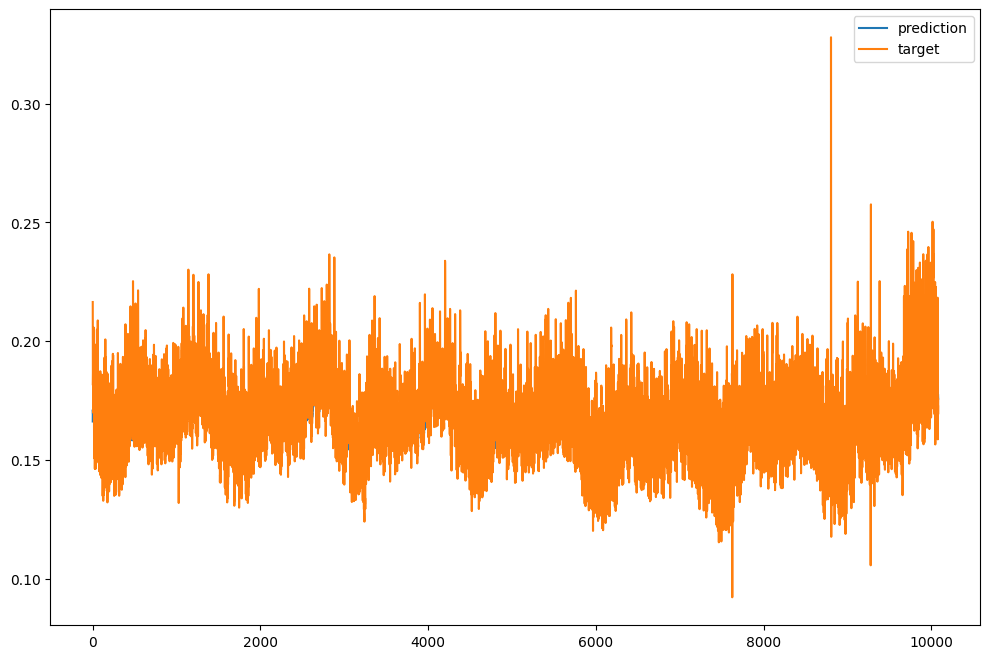

In [43]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

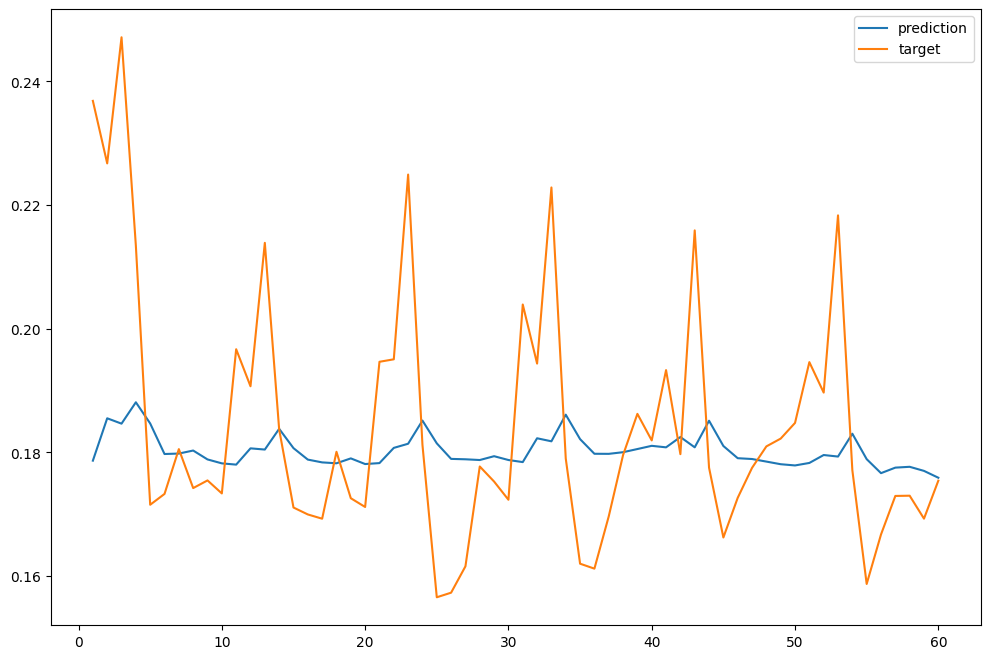

In [44]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [45]:
np.mean(time_list)

0.9730522388030612

1step과 비교했을때level을 맞추면서 sliding을 하게됨

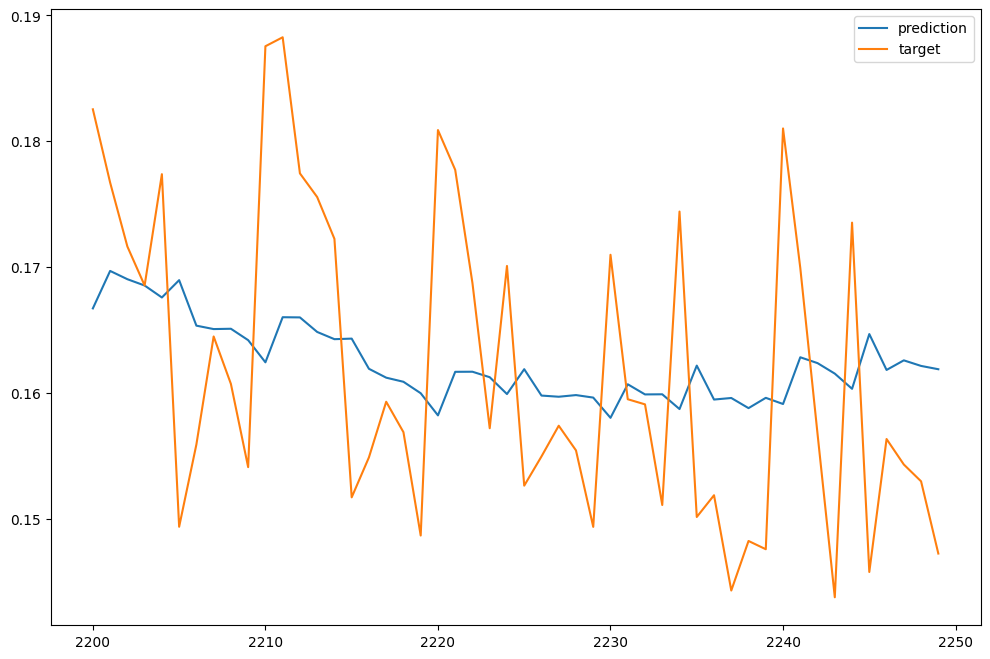

In [46]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()